In [321]:
from urllib2 import urlopen, URLError
from bs4 import BeautifulSoup
import pandas as pd

def parse_rows(rows):
    """ Get data from rows """
    results = []
    for row in rows:
        table_headers = row.find_all('th')
        if table_headers:
            results.append([headers.get_text() for headers in table_headers])

        table_data = row.find_all('td')
        if table_data:
            results.append([data.get_text() for data in table_data])
    return results

def get_table_from_url(url):
    try:
        resp = urlopen(url)
    except URLError as e:
        print 'An error occured fetching %s \n %s' % (url, e.reason)   
        return 1
    soup = BeautifulSoup(resp.read())

    # get table
    try:
        table = soup.find('table')
    except AttributeError as e:
        print 'No tables found, exiting'
        return 1

def is_valid_table(tag):
    if not tag.has_key("class"): 
        return False
    return tag.name == "table" and "stats_table" in tag["class"] and "sortable" in tag["class"]

def is_valid_row(tag):
    if not tag.name == "tr": return False
    if not tag.has_key("class"): return True  # permissive
    return "league_average_table" not in tag["class"] and "stat_total" not in tag["class"]

    
def get_tables_from_url(url):
    try:
        resp = urlopen(url)
    except URLError as e:
        print 'An error occured fetching %s \n %s' % (url, e.reason)   
        return 1
    soup = BeautifulSoup(resp.read())

    # get tables
    try:
        # deterimine if tables have useful data
        tables = soup.find_all(is_valid_table)
        return tables
    except AttributeError as e:
        print 'No tables found, exiting'
        return 1

def get_table_data(table):
    # Get rows
    try:
        rows = table.find_all('tr')
    except AttributeError as e:
        print 'No table rows found, exiting'
        return 1

    # Get data
    table_data = parse_rows(rows)
    
    # Transform into dataframe 
    table_data = pd.DataFrame(table_data)
    columns = table_data.ix[0]  # columns in first row
    table_data = table_data.ix[1:]  # data in remaining rows
    table_data.columns = columns  # st columns
    return table_data

def is_numeric(x):
    
    if isinstance(x, int) or isinstance(x, float):
        return True
    else:
        try:
            float(x.replace(',','').replace('$',''))
            return True
        except:
            return False
    
def as_numeric(x):
    try:
        return int(x)
    except:
        return float(x)
    
def to_numeric(x):
    if is_numeric(x):
        if isinstance(x, unicode) or isinstance(x, str):
            return as_numeric(x.replace(',','').replace('$',''))
        else:
            return x
    else:
        return x

def format_values(x):
    if '%' in x:  # special case: values returned as percentages
        return .01 * to_numeric(x.replace('%',''))
    elif ':' in x: # special case: times
        hour, minutes = x.split(':')
        hour = to_numeric(hour)
        minutes = float(to_numeric(minutes))/60
        return hour + minutes
    else:
        return to_numeric(x)

def format_columns(df):
    for col in df.columns:
        df[col] = df[col].apply(format_values)
    return df

In [322]:
x = '$2,000.12'
is_numeric('$77,725,000')
to_numeric(x)

2000.12

### Format columns to numeric values

In [7]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


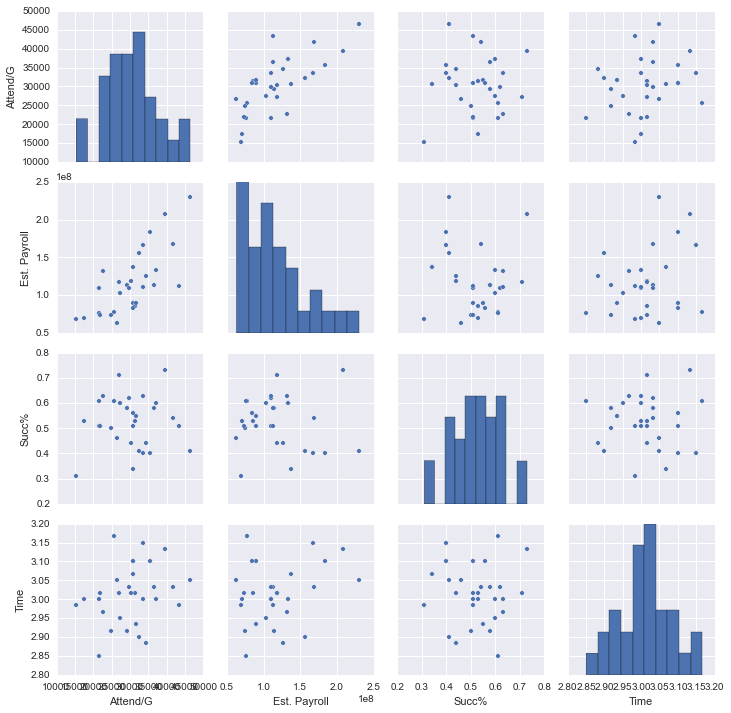

In [8]:
sns.pairplot(table_data[['Attend/G','Est. Payroll','Succ%','Time']]);

In [323]:
verbose = True

def parse_columns(table):
    headers = table.find("thead").find_all("th")
    column_names = []
    for header in headers:
        if header.string is None: 
            base_column_name = ''.join([v.string.strip() for v in header.contents])
        else: 
            base_column_name = header.string.strip()
        if base_column_name in column_names:
            i = 1
            column_name = base_column_name + "_%s" % str(i)
            while column_name in column_names:
                i += 1
                column_name = base_column_name + "_%s" % str(i)
            if verbose: 
                if base_column_name == "":
                    print "Empty header relabeled as %s" % column_name
                else:
                    print "Header %s relabeled as %s" % (base_column_name, column_name)
        else:
            column_name = base_column_name
        column_names.append(column_name)
    return column_names

def is_valid_row(tag):
    if not tag.name == "tr": return False
    if not tag.has_key("class"): return True  # permissive
    return "league_average_table" not in tag["class"] and "stat_total" not in tag["class"]

def parse_entry(entry):
    entry_contents = entry.contents
    content_str = ''
    if entry_contents is not None:
        content_data = []
        for c in entry_contents:
            if c.name is None or c.name == 'a':
                content_str += c.string.strip()
    return content_str

def parse_rows(table):
    rows = table.find("tbody").find_all(is_valid_row)
    data = []
    for row in rows:
        entries = row.find_all("td")
        entry_data = [parse_entry(entry) for entry in entries]            
        data.append(entry_data)
            
    return data

def data_from_url(url, table_ids=None):
    
    # get tables
    tables = get_tables_from_url(url)
    
    # empty dataset
    data = {}
    for table in tables:
        table_id = table['id']
        
        if table_ids is not None and table_id not in table_ids:  # skip non-requested tables
            continue
        
        columns = parse_columns(table)
        rows = parse_rows(table)
        
        # create pandas dataframe from data
        df = pd.DataFrame(rows, columns=columns)
        
        # if more than half of columns in a row are bad, we ignore
        df.dropna(thresh=np.floor(len(df.columns)/2), inplace=True)
        
        # make columns useable and store in dataset
        data[table_id] = format_columns(df)
        
    return data

In [333]:
# url = "http://www.baseball-reference.com/leagues/MLB/2015-misc.shtml"
# url = "http://www.baseball-reference.com/players/a/aaronha01.shtml"
# url = "http://www.baseball-reference.com/teams/"
# url = "http://www.baseball-reference.com/teams/OAK/2014-schedule-scores.shtml"
url = "http://www.baseball-reference.com/teams/TOR/1979.shtml"
data = data_from_url(url)

Header PO relabeled as PO_1


In [334]:
data.keys()

['players_value_batting',
 'players_value_pitching',
 'team_batting',
 'team_pitching',
 'standard_fielding']

In [336]:
data['team_batting']

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,,Rick Cerone,25,136,514,469,47,112,27,...,0.294,0.358,0.652,76,168,5,1,3,4,1
1,2,,John Mayberry*,30,137,541,464,61,127,22,...,0.372,0.461,0.833,124,214,10,5,1,2,7
2,3,,Danny Ainge,20,87,331,308,26,73,7,...,0.269,0.286,0.554,50,88,8,2,7,2,1
3,4,,Alfredo Griffin#,21,153,689,624,81,179,22,...,0.333,0.364,0.697,89,227,10,5,16,4,0
4,5,,Roy Howell*,25,138,563,511,60,126,28,...,0.31,0.405,0.715,92,207,12,6,1,3,4
5,6,,Al Woods*,25,132,488,436,57,121,24,...,0.337,0.385,0.722,95,168,7,1,7,4,0
6,7,,Rick Bosetti,25,162,657,619,59,161,35,...,0.286,0.362,0.648,74,224,17,3,6,7,0
7,8,,Bob Bailor,27,130,465,414,50,95,11,...,0.297,0.287,0.585,59,119,6,6,4,5,2
8,9,,Rico Carty,39,132,512,461,48,118,26,...,0.322,0.39,0.713,92,180,21,1,0,4,4
10,10,OF,Otto Velez,28,99,325,274,45,79,21,...,0.396,0.529,0.925,148,145,8,3,2,0,2
